In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv('all_data_1g.csv')
df = df.dropna(subset=['pm25'])
df

,Unnamed: 0,Unnamed: 0_x,date,stacja,pm25,temperature_2m,relative_humidity_2m,wind_speed_10m,wind_direction_10m,cloud_cover,...,Unnamed: 0_y,lat,lon,nearest_road_dist_m,total_road_length_km,building_count,elevation,population,built_up_surface,built_up_volume
304,304,304,2016-01-13 16:00:00+00:00,KpToruDziewu,15.84460,1.1890,99.284134,16.394829,340.76923,100.0,...,7,53.028647,18.666103,97.101206,1339.475703,21483.0,66.0,139210.225255,9214588.0,83715434.0
307,307,307,2016-01-13 19:00:00+00:00,KpToruDziewu,9.81580,-0.2610,95.373870,11.609651,299.74478,99.0,...,7,53.028647,18.666103,97.101206,1339.475703,21483.0,66.0,139210.225255,9214588.0,83715434.0
308,308,308,2016-01-13 20:00:00+00:00,KpToruDziewu,8.96800,-0.6110,96.061860,9.255571,283.49576,96.0,...,7,53.028647,18.666103,97.101206,1339.475703,21483.0,66.0,139210.225255,9214588.0,83715434.0
321,321,321,2016-01-14 09:00:00+00:00,KpToruDziewu,8.30860,1.7390,93.073070,12.229406,222.61401,93.0,...,7,53.028647,18.666103,97.101206,1339.475703,21483.0,66.0,139210.225255,9214588.0,83715434.0
322,322,322,2016-01-14 10:00:00+00:00,KpToruDziewu,9.34480,1.9390,91.093544,11.592894,216.15828,54.0,...,7,53.028647,18.666103,97.101206,1339.475703,21483.0,66.0,139210.225255,9214588.0,83715434.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
350635,350635,350635,2019-12-31 19:00:00+00:00,ZpSzczAndrze,9.41298,3.6585,91.862840,14.658676,294.67685,17.0,...,59,53.380975,14.663347,26.632511,653.938328,12399.0,14.0,58834.908799,4068844.0,23983848.0
350636,350636,350636,2019-12-31 20:00:00+00:00,ZpSzczAndrze,34.82470,3.1585,93.482430,12.904882,292.98874,9.0,...,59,53.380975,14.663347,26.632511,653.938328,12399.0,14.0,58834.908799,4068844.0,23983848.0
350637,350637,350637,2019-12-31 21:00:00+00:00,ZpSzczAndrze,30.00260,2.7585,94.468340,13.104197,290.92456,10.0,...,59,53.380975,14.663347,26.632511,653.938328,12399.0,14.0,58834.908799,4068844.0,23983848.0
350638,350638,350638,2019-12-31 22:00:00+00:00,ZpSzczAndrze,27.14000,2.2585,95.466354,11.966954,285.70870,4.0,...,59,53.380975,14.663347,26.632511,653.938328,12399.0,14.0,58834.908799,4068844.0,23983848.0


In [7]:
#SZACOWANIE MIEJSCA POTRZEBNEGO

import numpy as np

n_sequences = 0
for _, group in df.groupby('stacja'):
    n_sequences += len(group) - LOOKBACK - FORECAST_HORIZON + 1

n_features = len(features)

# Rozmiar X i y w bajtach
bytes_X = n_sequences * LOOKBACK * n_features * 4  # float32 = 4 bajty
bytes_y = n_sequences * FORECAST_HORIZON * 4

# Konwersja na MB i GB
size_X_MB = bytes_X / (1024**2)
size_y_MB = bytes_y / (1024**2)
total_GB = (bytes_X + bytes_y) / (1024**3)

print(f"Liczba sekwencji: {n_sequences}")
print(f"X zajmie: {size_X_MB:.2f} MB")
print(f"y zajmie: {size_y_MB:.2f} MB")
print(f"Łącznie: {total_GB:.2f} GB")


Liczba sekwencji: 316260
X zajmie: 2200.54 MB
y zajmie: 28.95 MB
Łącznie: 2.18 GB


In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import StandardScaler

# --- PARAMETRY ---
LOOKBACK = 96
FORECAST_HORIZON = 24
BATCH_SIZE = 64

# --- KONWERSJA DAT ---
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['hour'] = df['date'].dt.hour
df['weekday'] = df['date'].dt.weekday
df = df.sort_values(['stacja', 'date'])

# --- CECHY ---
features = [
    'temperature_2m', 'wind_speed_10m', 'wind_direction_10m',
    'cloud_cover', 'surface_pressure', 'dew_point_2m',
    'precipitation', 'relative_humidity_2m',
    'boundary_layer_height', 'nearest_road_dist_m', 'total_road_length_km',
    'building_count', 'elevation', 'population', 'built_up_surface',
    'built_up_volume', 'month', 'day', 'weekday'
]
target = 'pm25'

# --- PODZIAŁ WG LAT ---
train_years = [2016, 2017, 2018]
val_years = [2019]

df_train = df[df['date'].dt.year.isin(train_years)]
df_val = df[df['date'].dt.year.isin(val_years)]

# --- SKALERY: dopasowujemy RAZ ---
scaler_X = StandardScaler()
scaler_y = StandardScaler()
scaler_X.fit(df_train[features])
scaler_y.fit(df_train[[target]])

# --- FUNKCJA TWORZENIA SEKWENCJI ---
def create_sequences(data, feature_cols, target_col, lookback, forecast_horizon):
    X, y = [], []
    for i in range(len(data) - lookback - forecast_horizon + 1):
        seq_x = data[feature_cols].iloc[i:i+lookback].values
        seq_y = data[target_col].iloc[i+lookback:i+lookback+forecast_horizon].values
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)

# --- GENERATOR ---
class LSTMDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, df, features, target, lookback, forecast_horizon, batch_size, scalers):
        self.df = df
        self.features = features
        self.target = target
        self.lookback = lookback
        self.forecast_horizon = forecast_horizon
        self.batch_size = batch_size
        self.scaler_X, self.scaler_y = scalers
        self.groups = list(df.groupby('stacja'))
        self.index_map = []
        for g_idx, (_, group) in enumerate(self.groups):
            n = len(group)
            for start in range(n - lookback - forecast_horizon + 1):
                self.index_map.append((g_idx, start))

    def __len__(self):
        return int(np.ceil(len(self.index_map) / self.batch_size))

    def __getitem__(self, idx):
        batch_indices = self.index_map[idx*self.batch_size:(idx+1)*self.batch_size]
        X_batch, y_batch = [], []
        for g_idx, start in batch_indices:
            group = self.groups[g_idx][1].sort_values('date').reset_index(drop=True)
            scaled_features = self.scaler_X.transform(group[self.features]).astype(np.float32)
            scaled_target = self.scaler_y.transform(group[[self.target]]).astype(np.float32)
            scaled_df = pd.DataFrame(scaled_features, columns=self.features)
            scaled_df[self.target] = scaled_target
            seq_x = scaled_df[self.features].iloc[start:start+self.lookback].values
            seq_y = scaled_df[self.target].iloc[start+self.lookback:start+self.lookback+self.forecast_horizon].values
            X_batch.append(seq_x)
            y_batch.append(seq_y)
        return np.array(X_batch, dtype=np.float32), np.array(y_batch, dtype=np.float32)

# --- GENERATORY ---
train_gen = LSTMDataGenerator(df_train, features, target, LOOKBACK, FORECAST_HORIZON, BATCH_SIZE, (scaler_X, scaler_y))
val_gen = LSTMDataGenerator(df_val, features, target, LOOKBACK, FORECAST_HORIZON, BATCH_SIZE, (scaler_X, scaler_y))

# --- MODEL ---
model = Sequential()
model.add(LSTM(32, activation='relu', input_shape=(LOOKBACK, len(features))))
model.add(Dense(FORECAST_HORIZON))
model.compile(optimizer='adam', loss='mse')

# --- TRENING ---
history = model.fit(train_gen, epochs=1, validation_data=val_gen, verbose=1)

# --- PREDYKCJE I ODWROTNE SKALOWANIE ---
y_pred_rescaled_list = []
y_true_rescaled_list = []

for i in range(len(val_gen)):
    X_batch, y_batch = val_gen[i]
    y_pred_batch = model.predict(X_batch, verbose=0)
    y_pred_rescaled_batch = scaler_y.inverse_transform(y_pred_batch)
    y_true_rescaled_batch = scaler_y.inverse_transform(y_batch)
    y_pred_rescaled_list.append(y_pred_rescaled_batch)
    y_true_rescaled_list.append(y_true_rescaled_batch)

y_pred_rescaled = np.vstack(y_pred_rescaled_list)
y_val_rescaled = np.vstack(y_true_rescaled_list)



c:\Users\szymo\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\szymo\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3633/3633 ━━━━━━━━━━━━━━━━━━━━ 0s 807ms/step - loss: 0.9229

c:\Users\szymo\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3633/3633 ━━━━━━━━━━━━━━━━━━━━ 3439s 946ms/step - loss: 0.7388 - val_loss: 0.3039


C:\Users\szymo\AppData\Local\Temp\ipykernel_19208\2289778717.py:33: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


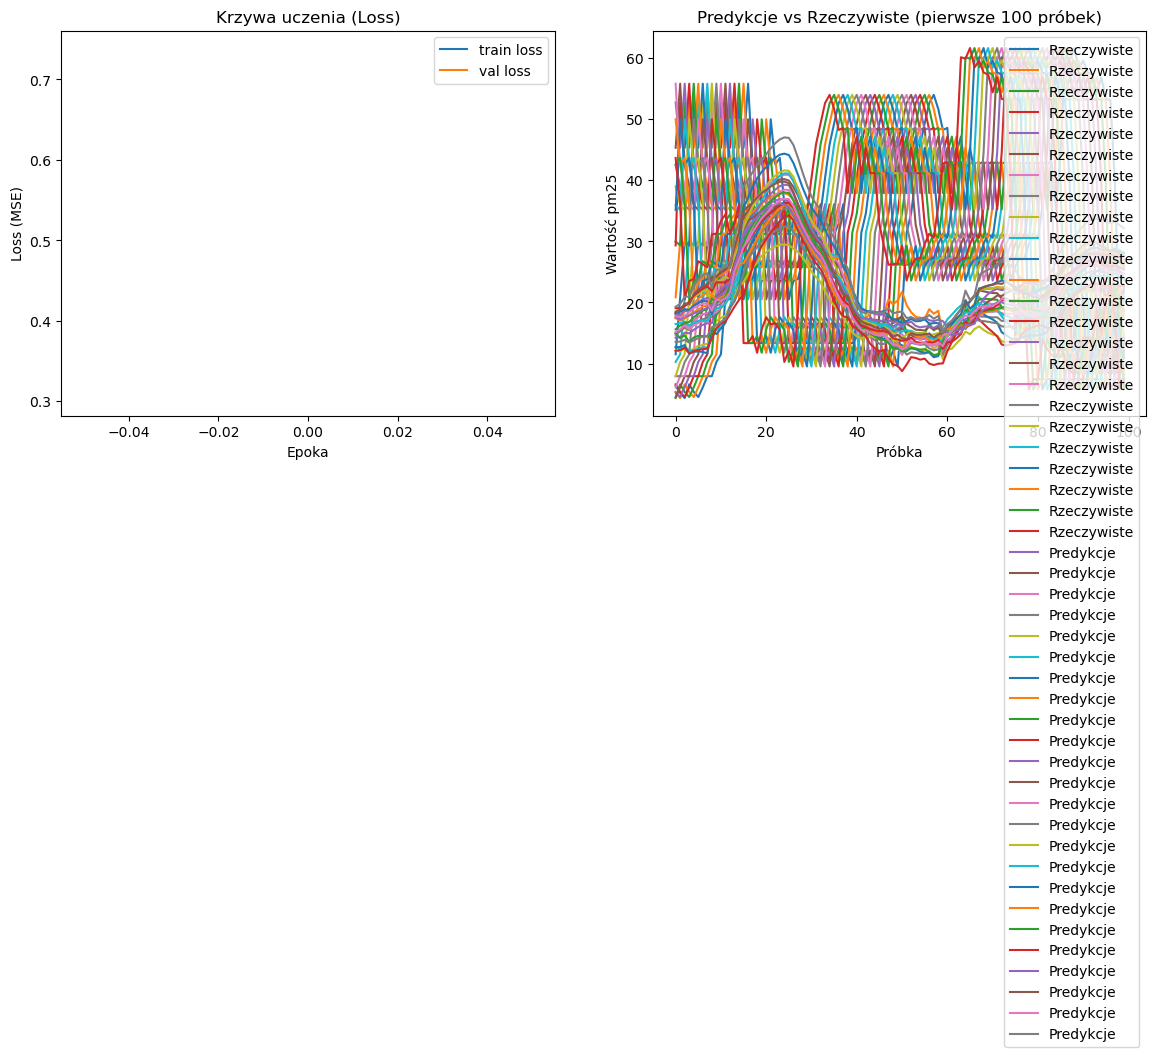

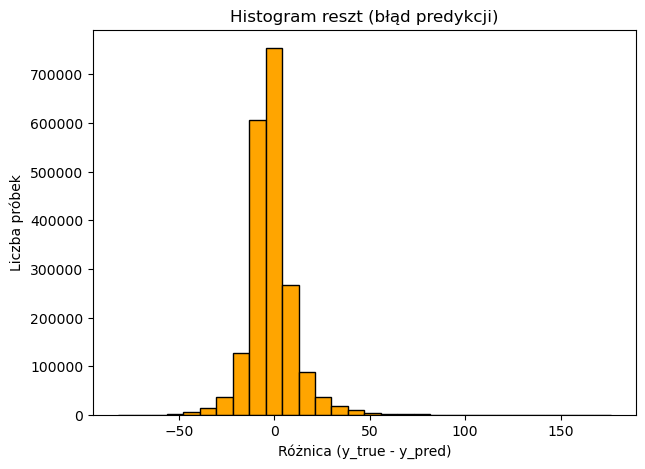

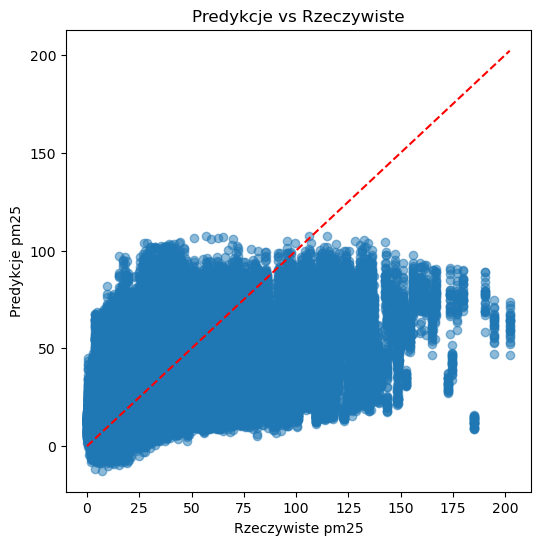

MAE: 8.400
RMSE: 12.409
R^2: 0.313


In [3]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def plot_lstm_diagnostics(history, y_test_rescaled, y_pred_rescaled):
    """
    Rysuje wykresy diagnostyczne po trenowaniu LSTM.

    Args:
        history: Obiekt zwrócony przez model.fit() (historia treningu).
        y_test_rescaled: Prawdziwe wartości (odwrócone skalowanie), np. pm25.
        y_pred_rescaled: Predykcje modelu (odwrócone skalowanie).
    """

    # 1. Krzywa uczenia
    plt.figure(figsize=(14,5))
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'], label='train loss')
    plt.plot(history.history.get('val_loss', []), label='val loss')
    plt.title('Krzywa uczenia (Loss)')
    plt.xlabel('Epoka')
    plt.ylabel('Loss (MSE)')
    plt.legend()

    # 2. Porównanie predykcji i prawdziwych wartości (np. pierwsze 100 próbek)
    plt.subplot(1,2,2)
    plt.plot(y_test_rescaled[:100], label='Rzeczywiste')
    plt.plot(y_pred_rescaled[:100], label='Predykcje')
    plt.title('Predykcje vs Rzeczywiste (pierwsze 100 próbek)')
    plt.xlabel('Próbka')
    plt.ylabel('Wartość pm25')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # 3. Histogram reszt
    residuals = y_test_rescaled.flatten() - y_pred_rescaled.flatten()
    plt.figure(figsize=(7,5))
    plt.hist(residuals, bins=30, color='orange', edgecolor='k')
    plt.title('Histogram reszt (błąd predykcji)')
    plt.xlabel('Różnica (y_true - y_pred)')
    plt.ylabel('Liczba próbek')
    plt.show()

    # 4. Scatter plot: predykcje vs rzeczywiste
    plt.figure(figsize=(6,6))
    plt.scatter(y_test_rescaled, y_pred_rescaled, alpha=0.5)
    plt.plot([y_test_rescaled.min(), y_test_rescaled.max()],
             [y_test_rescaled.min(), y_test_rescaled.max()], 'r--')  # linia y=x
    plt.title('Predykcje vs Rzeczywiste')
    plt.xlabel('Rzeczywiste pm25')
    plt.ylabel('Predykcje pm25')
    plt.show()

    # 5. Metryki
    mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
    rmse = mean_squared_error(y_test_rescaled, y_pred_rescaled, squared=False)
    r2 = r2_score(y_test_rescaled, y_pred_rescaled)

    print(f'MAE: {mae:.3f}')
    print(f'RMSE: {rmse:.3f}')
    print(f'R^2: {r2:.3f}')

plot_lstm_diagnostics(history, y_val_rescaled, y_pred_rescaled)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def plot_lstm_diagnostics_multistep(history, y_test_rescaled, y_pred_rescaled):
    """
    Rysuje diagnostykę po trenowaniu LSTM (multi-step forecast).
    
    Args:
        history: historia z model.fit()
        y_test_rescaled: macierz (n_samples, forecast_horizon)
        y_pred_rescaled: macierz (n_samples, forecast_horizon)
    """

    forecast_horizon = y_test_rescaled.shape[1]

    # 1. Krzywa uczenia
    plt.figure(figsize=(14,5))
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'], label='train loss')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='val loss')
    plt.title('Krzywa uczenia (Loss)')
    plt.xlabel('Epoka')
    plt.ylabel('Loss (MSE)')
    plt.legend()

    # 2. Porównanie predykcji i prawdziwych wartości dla 1. dnia
    plt.subplot(1,2,2)
    plt.plot(y_test_rescaled[:100, 0], label='Rzeczywiste - Dzień 1')
    plt.plot(y_pred_rescaled[:100, 0], label='Predykcje - Dzień 1')
    plt.title('Predykcje vs Rzeczywiste (pierwsze 100 próbek, Dzień 1)')
    plt.xlabel('Próbka')
    plt.ylabel('pm25')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # 3. Histogram reszt dla całej prognozy
    residuals = (y_test_rescaled - y_pred_rescaled).flatten()
    plt.figure(figsize=(7,5))
    plt.hist(residuals, bins=30, color='orange', edgecolor='k')
    plt.title('Histogram reszt (błąd predykcji)')
    plt.xlabel('Różnica (y_true - y_pred)')
    plt.ylabel('Liczba próbek')
    plt.show()

    # 4. Scatter plot: predykcje vs rzeczywiste dla całej prognozy
    plt.figure(figsize=(6,6))
    plt.scatter(y_test_rescaled.flatten(), y_pred_rescaled.flatten(), alpha=0.3)
    lims = [
        min(y_test_rescaled.min(), y_pred_rescaled.min()),
        max(y_test_rescaled.max(), y_pred_rescaled.max())
    ]
    plt.plot(lims, lims, 'r--')
    plt.title('Predykcje vs Rzeczywiste (całość)')
    plt.xlabel('Rzeczywiste pm25')
    plt.ylabel('Predykcje pm25')
    plt.show()

    # 5. Metryki globalne
    mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
    rmse = mean_squared_error(y_test_rescaled, y_pred_rescaled, squared=False)
    r2 = r2_score(y_test_rescaled, y_pred_rescaled)
    bias = np.mean(y_pred_rescaled - y_test_rescaled)

    print("=== METRYKI GLOBALNE ===")
    print(f"MAE: {mae:.3f}")
    print(f"RMSE: {rmse:.3f}")
    print(f"R²: {r2:.3f}")
    print(f"Bias: {bias:.3f}")

    # 6. Metryki i korelacje dla każdego dnia do przodu
    print("\n=== METRYKI PER DZIEŃ ===")
    for day in range(forecast_horizon):
        y_true_d = y_test_rescaled[:, day]
        y_pred_d = y_pred_rescaled[:, day]
        
        mse_d = mean_squared_error(y_true_d, y_pred_d)
        rmse_d = np.sqrt(mse_d)
        bias_d = np.mean(y_pred_d - y_true_d)
        r2_d = r2_score(y_true_d, y_pred_d)
        corr_d = np.corrcoef(y_true_d, y_pred_d)[0,1]

        print(f"\nDzień {day+1}:")
        print(f"  MSE: {mse_d:.3f}")
        print(f"  RMSE: {rmse_d:.3f}")
        print(f"  Bias: {bias_d:.3f}")
        print(f"  R²: {r2_d:.3f}")
        print(f"  Korelacja: {corr_d:.3f}")

        # Wykres korelacji
        plt.figure(figsize=(5,5))
        sns.scatterplot(x=y_true_d, y=y_pred_d, alpha=0.5)
        lims = [
            min(y_true_d.min(), y_pred_d.min()),
            max(y_true_d.max(), y_pred_d.max())
        ]
        plt.plot(lims, lims, 'r--')
        plt.xlabel('Rzeczywiste')
        plt.ylabel('Predykcje')
        plt.title(f'Korelacja: Dzień {day+1}')
        plt.show()

plot_lstm_diagnostics_multistep(history, y_val_rescaled, y_pred_rescaled)

In [4]:
model.save('moj_model_lstm_wiwelezmiennych_24h.h5')  # zapis do pliku .h5